# Churn Analysis: Timing of Targeting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

# Create Dataset

In [2]:
df_ord_orig = pd.read_csv('../data/order_churn_data.csv')
df_cus_orig = pd.read_csv('../data/churn_dataset.csv')

In [3]:
# limit dataset to customers who came after 2017
cust_ids = df_cus_orig.loc[(df_cus_orig.first_order_created_datetime >= "2017-01-01")
                          & (df_cus_orig.last_order_created_datetime <= "2018-09-30")].customer_db_id
print(len(cust_ids), '/',  len(df_cus_orig))

33304 / 68891


In [4]:
df_ord = df_ord_orig.loc[df_ord_orig.customer_db_id.isin(cust_ids)]
df_cus = df_cus_orig.loc[df_cus_orig.customer_db_id.isin(cust_ids)]
df_ord = df_ord.merge(df_cus[['customer_db_id', 'customer_id', 'completed_orders', 'last_order_created_datetime']], 
                      on=['customer_db_id', 'customer_id'], how='inner')

In [5]:
df_items = pd.read_csv('../data/input/items.csv')
df_items = df_items.groupby('order_id').agg({'quantity': 'sum', 'product_id': 'nunique'}).reset_index()
df_items = df_items.rename(columns={'product_id': 'num_products'})
df_ord = df_ord.merge(df_items, on=['order_id'], how='left')

In [6]:
df_braze = pd.read_csv('../data/braze_customers.csv')
df_braze = df_braze[['customer_id', 'email_subscribe', 'push_subscribe']]
df_braze.email_subscribe = df_braze.email_subscribe.isin(['subscribed', 'opted_in'])
df_braze.push_subscribe = df_braze.push_subscribe.isin(['subscribed', 'opted_in'])

df_ord = df_ord.merge(df_braze, on='customer_id', how='left')
df_ord.email_subscribe = df_ord.email_subscribe.fillna(False)
df_ord.push_subscribe = df_ord.push_subscribe.fillna(False)

In [7]:
df_ord = df_ord.drop(['cluster', 'cluster_name'], axis=1)
df_clusters = pd.read_csv('../data/clustering/item_clusters_cities.csv')
df_ord = df_ord.merge(df_clusters, on='order_id', how='left')

In [8]:
df_ord['days_since_last_seen'] = (datetime(2018,9,30) - pd.to_datetime(df_ord.last_order_created_datetime)).dt.days
df_ord.order_created_datetime = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_day'] = (df_ord.order_created_datetime - datetime(2017, 1, 1)).dt.days
df_ord['order_weekday'] = (df_ord.order_created_datetime).dt.weekday
df_ord['order_month'] = (df_ord.order_created_datetime).dt.month

In [9]:
df_ord = df_ord.drop_duplicates()

In [10]:
last_day = (datetime(2018,9,30) - datetime(2017,1,1)).days
last_day

637

### Completed Dataset

In [11]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])
df_comp['order_created_datetime'] = pd.to_datetime(df_comp.order_created_datetime)

# completed orders
df_comp['completed_orders'] = df_comp.groupby(['customer_db_id']).transform('count')
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [12]:
df_comp['first_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('min')
df_comp['last_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('max')
df_comp['lifetime'] = (df_comp.last_completed_order - df_comp.first_completed_order).dt.days
df_comp['first_completed_order_day'] = (df_comp.first_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['last_completed_order_day'] = (df_comp.last_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['order_day'] = (df_comp.order_created_datetime - datetime(2017, 1, 1)).dt.days

# Customer Lifetime
Created dataframe for customer lifetime

In [13]:
df_life = df_comp.copy()
df_life = df_life.sort_values(['customer_id', 'order_day'])

df_life['first_order'] = df_life.order_comp_num == 0
df_life['last_order'] = df_life.order_comp_num == (df_life.completed_orders - 1)
df_life['returned'] = ~df_life.last_order

df_life['frequency'] = df_life.groupby('customer_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())
df_life['order_day_expected'] = df_life.order_day + df_life.frequency
df_life.order_day_expected = df_life.groupby('customer_id').order_day_expected.shift().fillna(df_life.order_day)
df_life['order_expected_diff'] = df_life.order_day - df_life.order_day_expected

df_life['churn_factor'] = df_life.days_until_next_comp / df_life.frequency
df_life.loc[df_life.last_order, 'churn_factor'] = df_life.days_since_last_seen / df_life.frequency

df_life['order_day_expected_45'] = df_life.order_day + 45 + 8
df_life.order_day_expected_45 = df_life.groupby('customer_id').order_day_expected_45.shift().fillna(df_life.order_day)
df_life['order_expected_45_diff'] = df_life.order_day - df_life.order_day_expected_45

df_life['churned_after'] = df_life.days_until_next_comp > (45 + 8)
df_life.loc[df_life.last_order, 'churned_after'] = df_life.days_since_last_seen > (45 + 8)
df_life['churned_before'] = df_life.groupby('customer_id').churned_after.shift().fillna(False)
df_life.loc[df_life.churned_after, 'entered_inactive'] = df_life.order_day + 45 + 8

df_life['revenue_voucher'] = df_life.revenue + df_life.voucher_value
df_life.loc[~(df_life.voucher_value > 0), 'voucher_channel'] = 'no_voucher'
df_life['voucher_ratio'] = (df_life.voucher_value / df_life.revenue_voucher).round(1)

df_life['returned_CRM'] = df_life.final_click_channel.str.contains('crm')
df_life['returned_CRM'] = df_life.groupby('customer_id').returned_CRM.shift(-1).fillna(False)
df_life['returned_voucher'] = df_life.groupby('customer_id').voucher_value.shift(-1).fillna(0)
df_life['returned_voucher'] = (df_life.returned_voucher > 0)
df_life['over_frequency'] = df_life.churn_factor >= 1
df_life['freq_median'] = df_life.groupby('order_day')['frequency'].transform('median')

In [14]:
df_life.voucher_channel = df_life.voucher_channel.fillna('unknown')

### Sample Customer

In [15]:
def plot_customer_lifetime(sample_customer):
    df_life_sample = df_life.loc[df_life.customer_id == sample_customer]
    
    fig, ax = plt.subplots(figsize=(10,5))
    # plot vouchers
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.voucher_value > 0], 
                    x='order_day', y='voucher_value', marker='x', color='black', label='voucher_value')
    
    # plot journey and expected journy
    sns.lineplot(data=df_life_sample, x='order_day', y='revenue_voucher', 
                 marker='o', label='order revenue', color='green')
    sns.lineplot(data=df_life_sample, x='order_day_expected', y='revenue_voucher', 
                 marker='o', label='expected_order', color='gray', alpha=0.3)
    
    # plot final click channel
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.final_click_channel.str.contains('crm')],
                   x='order_day', y='revenue_voucher', color='red', label='crm_click', zorder=10)
    
    # plot entering inactive segment
    sns.rugplot(df_life_sample.entered_inactive, color='black', height=1, linestyle='--', label='inactive')
    

    plt.xticks(rotation=70)
    plt.ylim(0)
    plt.title(sample_customer)
    plt.legend()
    plt.show()

In [16]:
samples = df_ord.loc[(df_ord.days_until_next_order > 50) & (df_ord.completed_orders > 3) & (df_ord.order_num == 2)]['customer_id'].sample(3)
samples

19687    CUS-W-SZ-63629894
2736          CUS-M2415758
38113         CUS-K7764269
Name: customer_id, dtype: object

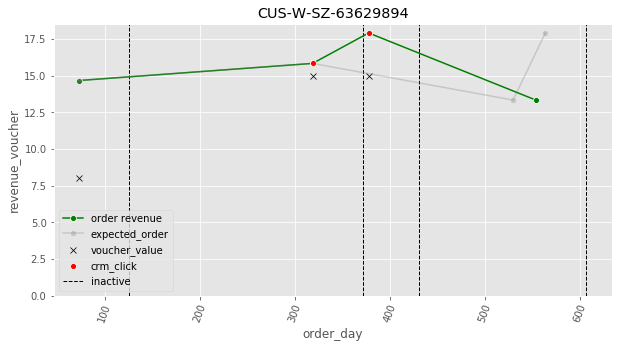

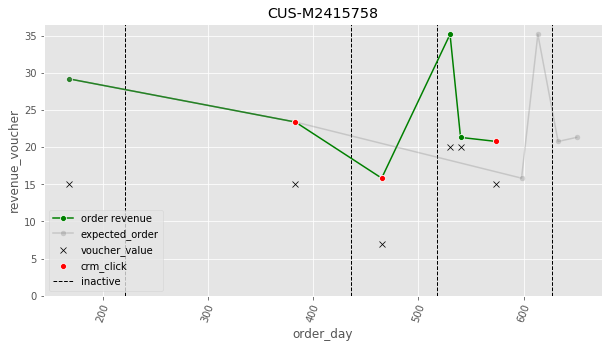

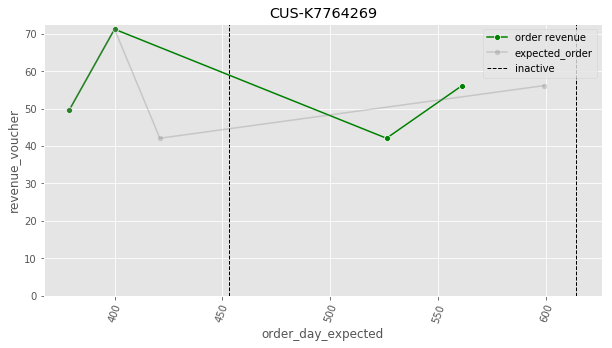

In [17]:
for s in samples:
    plot_customer_lifetime(s)

# Active Customers
- How does timing of churn impact if customers return

### Prediction: IOF

count    40514.000000
mean         2.658542
std         49.974405
min       -560.000000
25%         -8.000000
50%          0.000000
75%          9.300000
max        560.000000
Name: order_expected_diff, dtype: float64

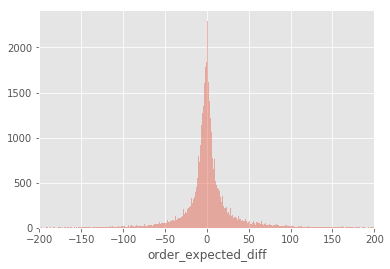

In [18]:
a = df_life.loc[df_life.order_comp_num > 1]
sns.distplot(a.order_expected_diff, bins=1000, kde=False)
plt.xlim(-200,200)
a.order_expected_diff.describe()

In [19]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected)

23.594522853990572

### Prediction: 45 Days

In [20]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected_45)

37.119069951128004

count    40514.000000
mean       -17.771437
std         45.514431
min        -53.000000
25%        -41.000000
50%        -32.000000
75%        -13.000000
max        542.000000
Name: order_expected_45_diff, dtype: float64

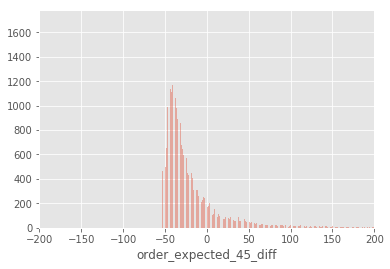

In [21]:
sns.distplot(a.order_expected_45_diff, bins=1000, kde=False)
plt.xlim(-200,200)
a.order_expected_45_diff.describe()

## Group customers based on frequency
- good timing: if frequency 53 (45+8) days +/- 7 days
- soon: if frequency > 53+7
- late: if frequency < 53-7

In [22]:
df_life_2 = df_life.loc[df_life.order_comp_num > 1]
df_life_2['target_timing'] = ['soon' if x >= 53+7 else 'late' if x <= 53-7 else 'correct' for x in df_life_2.frequency]

In [23]:
stats = df_life_2.loc[df_life_2.churned_after].groupby(['target_timing', 'returned'])['order_id'].nunique().reset_index()
stats['target_total'] = stats.groupby('target_timing')['order_id'].transform('sum')
stats['order_perc'] = stats.order_id / stats.target_total

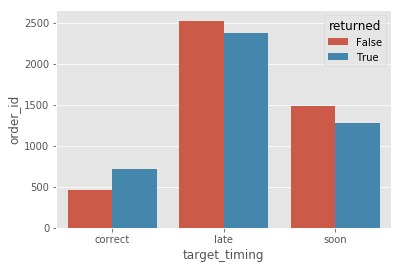

In [24]:
sns.categorical.barplot(data=stats, x='target_timing', y='order_id', hue='returned')

# New Customers

In [25]:
df_life0 = df_life.loc[(df_life.order_comp_num == 0) & ~df_life.last_order]
df_life0_v = df_life0.loc[df_life0.returned_voucher]
df_life0_nv = df_life0.loc[~df_life0.returned_voucher]
df_life1 = df_life.loc[(df_life.order_comp_num > 0) & ~df_life.last_order]

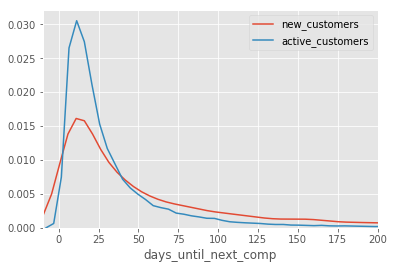

In [26]:
sns.distplot(df_life0.days_until_next_comp, norm_hist=True, hist=False, label='new_customers')
sns.distplot(df_life1.days_until_next_comp, norm_hist=True, hist=False, label='active_customers')
plt.xlim(-10,200)
plt.legend()
plt.show()

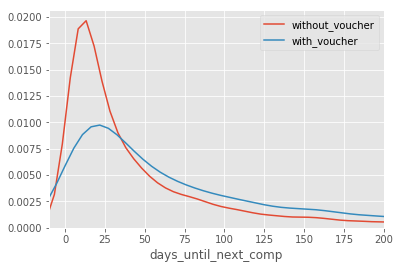

In [27]:
sns.distplot(df_life0_nv.days_until_next_comp, norm_hist=True, hist=False, label='without_voucher')
sns.distplot(df_life0_v.days_until_next_comp, norm_hist=True, hist=False, label='with_voucher')
plt.xlim(-10,200)
plt.legend()

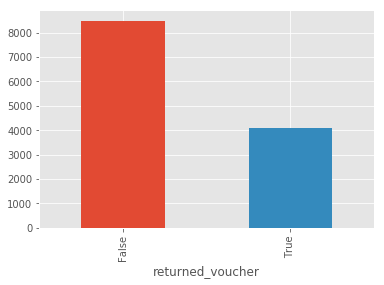

In [28]:
df_life0.groupby('returned_voucher')['customer_db_id'].nunique().plot(kind='bar')

# Remove Outliers
- remove people who came through voucher
- limit to 90 days

In [295]:
df_life0_out = df_life0.loc[(df_life0.days_until_next_comp <= 100) & ~(df_life0.returned_voucher)]

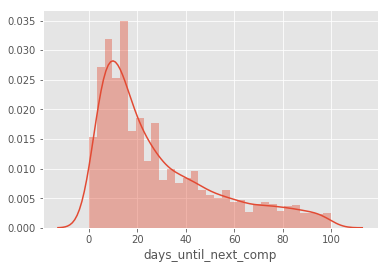

In [296]:
sns.distplot(df_life0_out.days_until_next_comp, norm_hist=True, hist=True)

In [297]:
df_life0_out.days_until_next_comp.describe()

count    7101.000000
mean       28.653992
std        24.375383
min         0.000000
25%        10.000000
50%        20.000000
75%        42.000000
max       100.000000
Name: days_until_next_comp, dtype: float64

# Baseline

In [298]:
def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

In [299]:
df_error = pd.DataFrame(index=range(1,60), columns=['mae', 'rmse'], dtype=np.int)
for days_threshold in range(1,60):
    mae = metrics.mean_absolute_error(df_life0_out.days_until_next_comp, np.ones(len(df_life0_out)) * days_threshold)
    df_error.loc[days_threshold, 'mae'] = mae
    mse = metrics.mean_squared_error(df_life0_out.days_until_next_comp, np.ones(len(df_life0_out)) * days_threshold)
    df_error.loc[days_threshold, 'rmse'] = np.sqrt(mse)

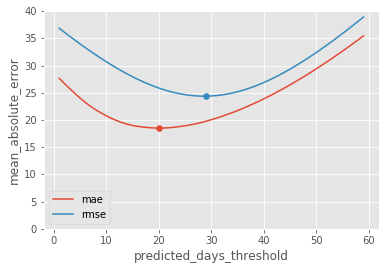

In [300]:
df_error['mae'].plot(label='mae')
df_error['rmse'].plot(label='rmse')
plt.scatter(df_error.mae.argmin(), df_error.mae.min())
plt.scatter(df_error.rmse.argmin(), df_error.rmse.min())
plt.xlabel('predicted_days_threshold')
plt.ylabel('mean_absolute_error')
plt.ylim(0)
plt.legend()
plt.show()

In [301]:
df_error.min()

mae     18.505563
rmse    24.376122
dtype: float64

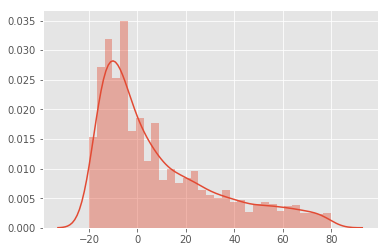

In [302]:
sns.distplot((df_life0_out.order_day + df_life0_out.days_until_next_comp) - (df_life0_out.order_day + 20))

# Create Features

In [303]:
sorted(df_life0.columns.tolist())

['activity_state',
 'aov',
 'churn_factor',
 'churned_after',
 'churned_before',
 'city',
 'cluster',
 'completed_orders',
 'corporate',
 'customer_db_id',
 'customer_id',
 'customer_rescheduled',
 'days_since_last_comp',
 'days_since_last_order',
 'days_since_last_seen',
 'days_until_next_comp',
 'days_until_next_order',
 'delay_mins_DO',
 'delay_mins_PU',
 'driver_db_id_DO',
 'driver_db_id_PU',
 'email',
 'email_subscribe',
 'entered_inactive',
 'fac_name',
 'final_click_channel',
 'final_click_no_voucher',
 'first_completed_order',
 'first_completed_order_day',
 'first_order',
 'freq_median',
 'frequency',
 'gender',
 'internal_rescheduled',
 'last_completed_order',
 'last_completed_order_day',
 'last_order',
 'last_order_created_datetime',
 'lifetime',
 'newsletter_optin',
 'num_customer_reschedules',
 'num_internal_reschedules',
 'num_orders',
 'num_products',
 'order_comp_num',
 'order_created_datetime',
 'order_day',
 'order_day_expected',
 'order_day_expected_45',
 'order_db_id

In [416]:
def create_feature(df, groupby_col, agg_col, transformation, new_col_name):
    df[new_col_name] = df.groupby(groupby_col)[agg_col].transform(transformation).fillna(0).round()
    return df

In [417]:
transforms = ['mean', 'std', 'median']
for t in transforms:
    df_life0_out = create_feature(df_life0_out, 'cluster', 'days_until_next_comp', t, 'cluster_freq_' + t)
    df_life0_out = create_feature(df_life0_out, 'order_month', 'days_until_next_comp', t, 'month_freq_' + t)
    df_life0_out = create_feature(df_life0_out, 'order_month', 'revenue', t, 'month_rev_' + t)
    df_life0_out = create_feature(df_life0_out, 'city', 'days_until_next_comp', t, 'city_freq_' +t)
    df_life0_out = create_feature(df_life0_out, 'quantity', 'days_until_next_comp', t, 'quantity_freq_'+ t)

In [418]:
df_life0_out['service_class_paid'] = [True if x in ['PLUS', 'EXPRESS'] else False for x in df_life0_out.service_class]
df_life0_out['revenue_per_prod'] = df_life0_out.revenue / df_life0_out.quantity
df_life0_out['order_attempt_before'] = df_life0_out.order_comp_num != df_life0_out.order_num

# Predict days
- Find a model that predicts better than 18 days MAE

In [537]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, mutual_info_regression
from sklearn.neural_network import MLPRegressor

In [538]:
# features to predict
feats = [# aggregate features
         'cluster_freq_mean', 'cluster_freq_std', 'cluster_freq_median',
         'month_freq_mean', 'month_freq_std', 'month_freq_median',
         'month_rev_mean', 'month_rev_median',
         'city_freq_mean', 'city_freq_std', 'city_freq_median',
         'quantity_freq_mean', 'quantity_freq_std', 'quantity_freq_median',
         # order features
         'service_class_paid', 'revenue_per_prod', 'order_attempt_before', 'order_num',
         'city', 'revenue', 'voucher_ratio', 'gender', 'num_products', 
         'order_x', 'order_y', 'email_subscribe', 'corporate',
         'quantity', 'service_class', 'software_type', 'voucher_used', 'final_click_channel', 'order_month', 'cluster']
pred_name = ['days_until_next_comp']

In [539]:
df_pred = df_life0_out[feats + pred_name]
df_pred.shape

(7101, 35)

### Encode string columns

In [540]:
str_cols = df_pred.select_dtypes(['object']).columns.tolist()
for col in str_cols:
    df_pred = df_pred.merge(pd.get_dummies(df_pred[col], prefix=col), left_index=True, right_index=True)
    df_pred = df_pred.drop(col, axis=1)

In [541]:
df_pred.shape

(7101, 103)

### Round Numerical Columns


In [542]:
round_cols = ['revenue', 'freq_median']
for col in round_cols:
    try:
        df_pred[col] = df_pred[col].round()
    except:
        pass

### Fill NANs

In [543]:
nans = df_pred.isnull().sum()
nans = nans[nans > 0].sort_values(ascending=False)
nans

order_y    231
order_x    231
dtype: int64

In [544]:
df_pred = df_pred.fillna(0)

In [545]:
df_pred.head()

,cluster_freq_mean,cluster_freq_std,cluster_freq_median,month_freq_mean,month_freq_std,month_freq_median,month_rev_mean,month_rev_median,city_freq_mean,city_freq_std,...,cluster_P_10,cluster_P_11,cluster_P_2,cluster_P_3,cluster_P_4,cluster_P_5,cluster_P_6,cluster_P_7,cluster_P_8,cluster_P_9
53773,19.0,18.0,12.0,22.0,20.0,14.0,30.0,22.0,26.0,23.0,...,0,0,0,0,0,0,0,0,0,0
23734,39.0,28.0,34.0,21.0,18.0,14.0,34.0,25.0,32.0,26.0,...,0,0,1,0,0,0,0,0,0,0
81161,27.0,22.0,21.0,39.0,26.0,36.0,39.0,28.0,26.0,23.0,...,0,0,0,0,0,0,0,0,0,0
25594,31.0,24.0,25.0,30.0,24.0,21.0,32.0,24.0,32.0,26.0,...,0,1,0,0,0,0,0,0,0,0
68602,23.0,19.0,16.0,22.0,20.0,14.0,30.0,22.0,26.0,23.0,...,0,0,0,0,0,0,0,0,0,0


# Feature Selection

### Train / Test Set

In [546]:
test_size=0.1

In [547]:
X = df_pred.drop(pred_name, axis=1).values
y = df_pred[pred_name].values
X_norm = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train.shape, X_test.shape

((6390, 102), (711, 102))

In [548]:
sk = SelectPercentile(mutual_info_regression, percentile=20).fit(X, y)
df_sk = pd.DataFrame()
df_sk['feature'] = df_pred.drop(pred_name, 1).columns
df_sk['scores'] = sk.scores_

In [549]:
df_sk.sort_values('scores', ascending=False).head(20)

,feature,scores
2,cluster_freq_median,0.058028
0,cluster_freq_mean,0.055608
1,cluster_freq_std,0.048862
11,quantity_freq_mean,0.033296
25,quantity,0.030665
15,revenue_per_prod,0.026802
12,quantity_freq_std,0.025859
3,month_freq_mean,0.024382
13,quantity_freq_median,0.022484
6,month_rev_mean,0.021273


In [550]:
selected_feats = df_sk.sort_values('scores', ascending=False)[:20].feature.tolist()

In [551]:
# features from feature selection
X_feat = df_pred[selected_feats].values
X_feat_norm = StandardScaler().fit_transform(X_feat)

X_feat_train, X_feat_test, y_feat_train, y_feat_test = train_test_split(X_feat_norm, y, test_size=test_size, random_state=42)
X_feat_train.shape, X_feat_test.shape

((6390, 20), (711, 20))

In [552]:
# polynomial features
poly = PolynomialFeatures(2, interaction_only=True)
X_poly = poly.fit_transform(X_feat)
X_poly_norm = StandardScaler().fit_transform(X_poly)

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly_norm, y, test_size=test_size, random_state=42)
X_poly_train.shape, X_poly_test.shape

((6390, 211), (711, 211))

# PCA

In [553]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
X_pca_norm = StandardScaler().fit_transform(X_pca)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca_norm, y, test_size=test_size, random_state=42)
X_pca_train.shape, X_pca_test.shape

((6390, 6), (711, 6))

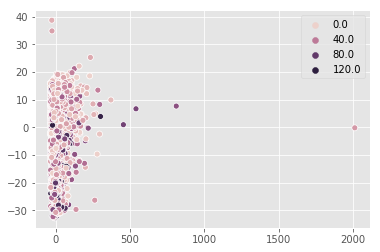

In [565]:
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=y.squeeze())

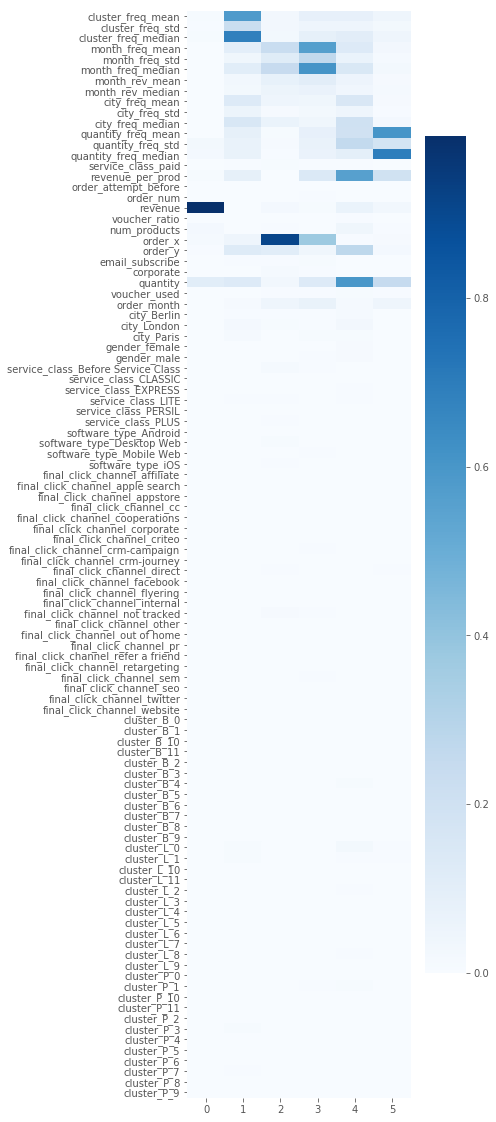

In [555]:
plt.figure(figsize=(5,20))
sns.heatmap(abs(pca.components_).T, yticklabels=df_pred.drop(pred_name, 1).columns, cmap='Blues')

# Outliers

In [480]:
from sklearn.ensemble import IsolationForest

iso_frst = IsolationForest()
X_iso = iso_frst.fit_predict(X_pca)
y_iso = y[X_iso > 0]
X_iso = X_pca[X_iso > 0]

X_iso_norm = StandardScaler().fit_transform(X_iso)

X_iso_train, X_iso_test, y_iso_train, y_iso_test = train_test_split(X_iso_norm, y_iso, test_size=test_size, random_state=42)
X_iso_train.shape, X_iso_test.shape

((5751, 103), (640, 103))

# Linear Regression

In [481]:
def cross_validation(model, X, y, splits=4):
    kf = KFold(n_splits=splits)
    error = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val).clip(y.min(), y.max())
        rmse = np.sqrt(metrics.mean_squared_error(y_val, y_pred))
        error.append(rmse)
        
    return np.array(error)

In [569]:
# all features
lin_reg = linear_model.LinearRegression()
cross_validation(lin_reg, X_train, y_train).mean()

22.95168989936745

In [483]:
# best 20 correlated features
lin_reg_feat = linear_model.LinearRegression()
cross_validation(lin_reg_feat, X_feat_train, y_feat_train).mean()

22.652807803408162

In [484]:
# best 20 correlated features polynomial
lin_reg_poly = linear_model.LinearRegression()
cross_validation(lin_reg_poly, X_poly_train, y_poly_train).mean()

23.001501558936756

In [485]:
# pca features
lin_reg_pca = linear_model.LinearRegression()
cross_validation(lin_reg_pca, X_pca_train, y_pca_train).mean()

22.92072174395844

In [486]:
# iso outliers features
lin_reg_iso = linear_model.LinearRegression()
cross_validation(lin_reg_iso, X_iso_train, y_iso_train).mean()

23.421472051693158

# MLP

In [487]:
mlp = MLPRegressor(hidden_layer_sizes=(100,), learning_rate_init=0.0003)
cross_validation(mlp, X_train, y_train).mean()

22.82897249186507

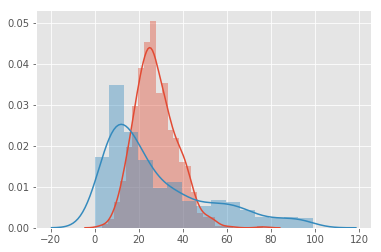

In [488]:
y_pred = mlp.predict(X_test)
sns.distplot(y_pred)
sns.distplot(y_test)

In [489]:
from sklearn.neighbors import KNeighborsRegressor
kneigh = KNeighborsRegressor(n_neighbors=10)
cross_validation(kneigh, X_feat_train, y_feat_train).mean()

23.468419951842883

In [492]:
m = kneigh.kneighbors_graph(X_feat_test)

In [494]:
m[0]

<1x4793 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

# Clustering

In [491]:
# find best number of clusters
k_range = range(1,15)
df_k_loss = pd.Series(index=k_range)
for k in k_range:
    kmeans_k = KMeans().fit(X_norm)
    df_k_loss[k] = kmeans_k.inertia_

KeyboardInterrupt: 

In [ ]:
df_k_loss.plot()

In [ ]:
kmeans = KMeans(5)
kmeans.fit(X_norm)

In [ ]:
plt.figure(figsize=(5,20))
sns.heatmap(kmeans.cluster_centers_.T, yticklabels=df_pred.drop(pred_name,1).columns, cmap='Blues')

In [ ]:
df_kmeans = df_pred.copy()
df_kmeans['kmeans'] = kmeans.labels_
df_kmeans.groupby('kmeans')['days_until_next_comp'].describe()

In [ ]:
rmse(df_kmeans.days_until_next_comp, df_kmeans.groupby('kmeans')['days_until_next_comp'].transform('mean'))

# PCA

In [ ]:
pca = PCA(2).fit(X_norm)
df_pca = pca.transform(X_norm)
df_pca = pd.DataFrame(df_pca)

In [ ]:
df_pca['cluster'] = kmeans.labels_
df_pca['weeks_until_next_comp'] = df_pred['days_until_next_comp'] // 7

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(df_pca[0], df_pca[1], hue=df_pca['cluster'], legend='full', palette='Dark2')

In [ ]:
pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(abs(pca.components_).T, yticklabels=df_train_X.columns, cmap='Blues')

In [ ]:
df_train['kmeans'] = kmeans.labels_
df_train['kmeans_median'] = df_train.groupby('kmeans').days_until_next_comp.transform('median')